# Logisitic smooth regression model

Following van der Wiel et al. 2019, let's model energy demand using a logistic smooth regression model: https://www.sciencedirect.com/science/article/pii/S1364032119302862

This takes a single predictor, daily mean temperature, and provides a smooth transition between two linear regimes.

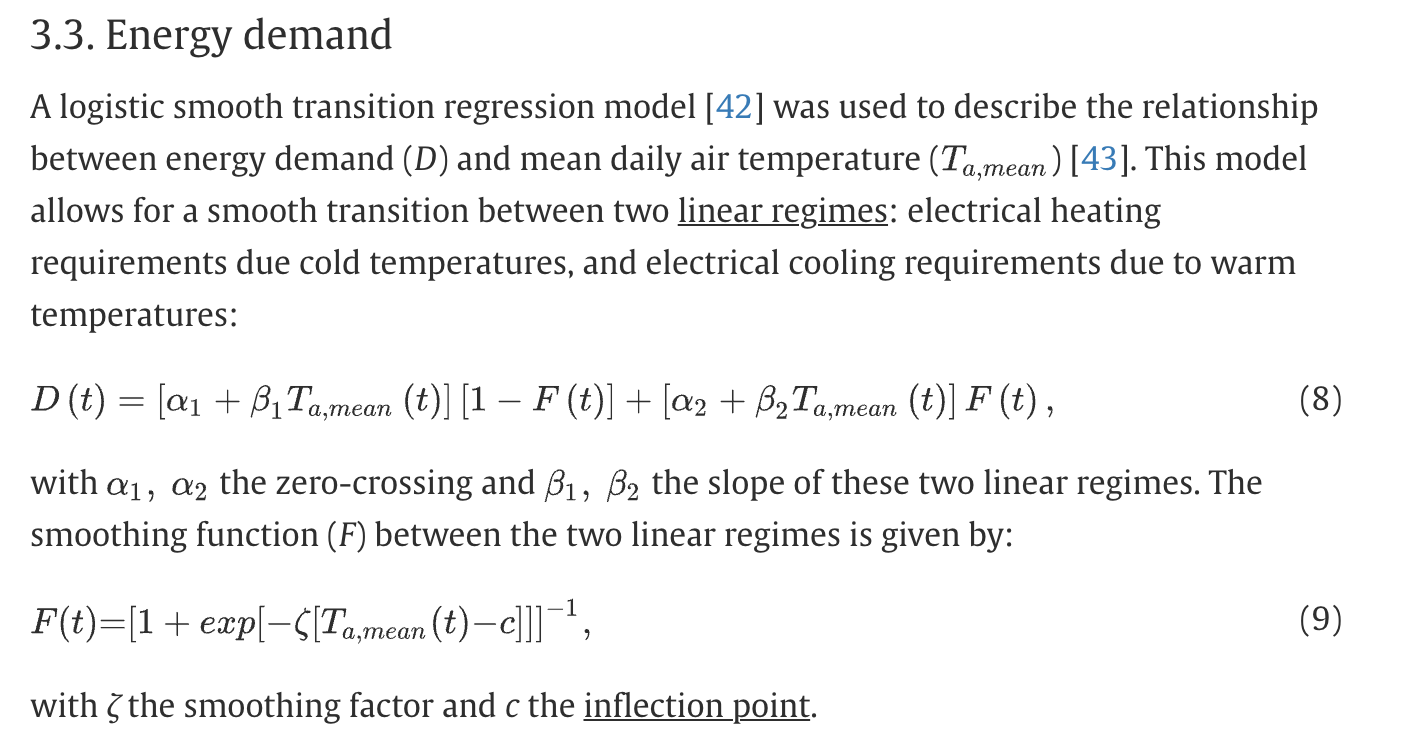

In [1]:
import xarray as xr
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt

In [2]:
path = "/g/data/w42/dr6273/work/projects/Aus_energy/"

# Load predictors and predictands

Detrended energy demand (predictand)

In [3]:
dem_da = xr.open_dataset(
    path + "/data/energy_demand/daily_demand_2010-2020_detrended.nc"
)["demand_dt"]

Daily mean temperature

In [4]:
t2m = xr.open_dataset(path + "demand_predictors/2t_era5_daily_1959-2022_NEM.nc")["t2m"]

# Plot demand versus temperature

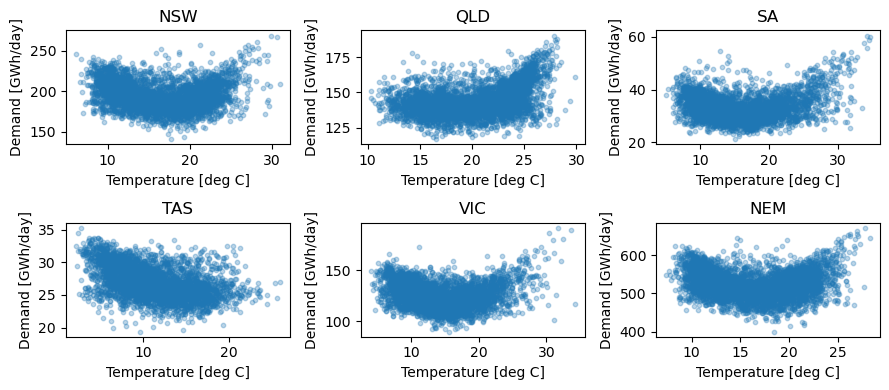

In [5]:
fig, ax = plt.subplots(2, 3, figsize=(9,4))
for i, region in enumerate(dem_da["region"].values):
    a = ax.flatten()[i]
    a.scatter(
        t2m.sel(region=region, time=dem_da["time"]) - 273.15,
        dem_da.sel(region=region) / 1000,
        alpha=0.3,
        s=10
    )
    a.set_xlabel("Temperature [deg C]")
    a.set_ylabel("Demand [GWh/day]")
    a.set_title(region)
plt.tight_layout()

# Explore

In [169]:
def F(x, z, c):
    return 1 / (1 + np.exp(-z * (x - c)))

In [174]:
x = np.arange(10, 1000, .1)

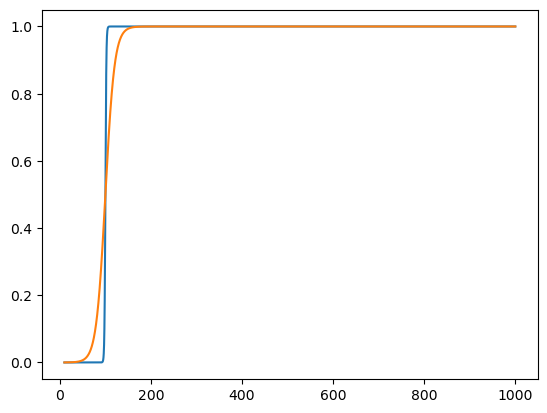

In [175]:
plt.plot(x, F(x, 1, 100))
plt.plot(x, F(x, 0.1, 100))

In [151]:
def term1(x, a1, b1, z, c):
    F_ = F(x, z, c)
    return (a1 + b1 * x) * (1 - F_)

In [152]:
def term2(x, a2, b2, z, c):
    F_ = F(x, z, c)
    return (a2 + b2 * x) * F_

In [153]:
def lstr(x, a1, a2, b1, b2, z, c):
    return term1(x, a1, b1, z, c) + term2(x, a2, b2, z, c)

In [154]:
y = term1(x, -4, -2, 0.5, 2)
y2 = term2(x, -8, 0.8, 0.5, 2)
l = lstr(x, -4, -8, -2, 0.8, 0.5, 2)

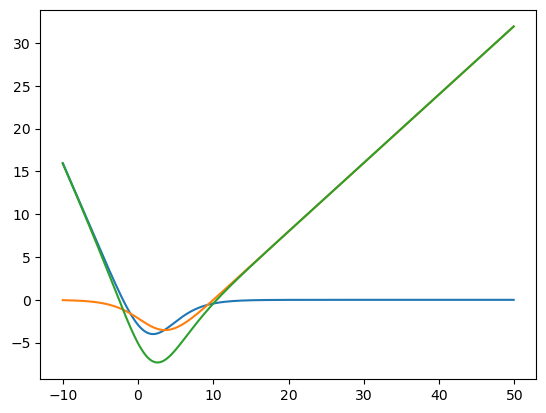

In [156]:
plt.plot(x, y)
plt.plot(x, y2)
plt.plot(x, l)

# Try using `scipy` `curve_fit`

In [56]:
from scipy.optimize import curve_fit

In [482]:
def lstr(x, a1, a2, b1, b2, z, c):
    """
    Logistic smooth transition equation
    """
    F = 1 / (1 + np.exp(-z * (x - c)))
    term1 = (a1 + b1 * x) * (1 - F)
    term2 = (a2 + b2 * x) * F
    return term1 + term2

In [483]:
# t2m_anoms = t2m.sel(region="NEM", time=dem_da.time) - t2m.sel(region="NEM", time=dem_da.time).mean("time")

In [484]:
# x = t2m_anoms #t2m.sel(region="NEM", time=dem_da.time).values

In [521]:
x = t2m.sel(region="NEM", time=dem_da.time)

In [522]:
# dem_anoms = dem_da.sel(region="NEM") - dem_da.sel(region="NEM").mean("time")

In [523]:
y = dem_da.sel(region="NEM")

In [524]:
# y = dem_anoms / 1000

In [525]:
# x = x.sel(time="2018")
# y = y.sel(time="2018")

In [526]:
x = x.values
y = y.values

In [527]:
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]

Need to guess starting parameter values otherwise fitting will fail

In [528]:
init = [-6e8, -4e6, 2e6, 2e4, 0.2, 290]

In [529]:
params, _ = curve_fit(lstr, x, y, p0=init, maxfev=25000)
a1, a2, b1, b2, z, c = params

In [530]:
# params, _ = curve_fit(term1, x, y, p0=[-6e8, 2e6, 0.2, 290], maxfev=25000)
# a1, b1, z, c = params

In [531]:
print(params)

[-6.35097980e+08 -4.96549516e+06  2.30496243e+06  1.84383639e+04
  2.20479623e-01  2.64774051e+02]


In [532]:
x_line = np.arange(min(x), max(x), 1)
y_line = lstr(x_line, a1, a2, b1, b2, z, c)

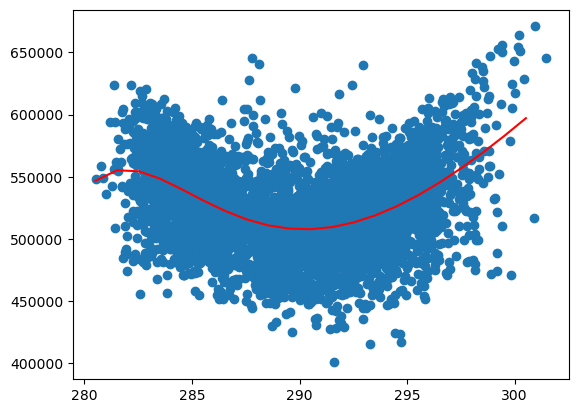

In [533]:
plt.scatter(x, y)
plt.plot(x_line, y_line, color="r")

In [534]:
pred = lstr(x, a1, a2, b1, b2, z, c)

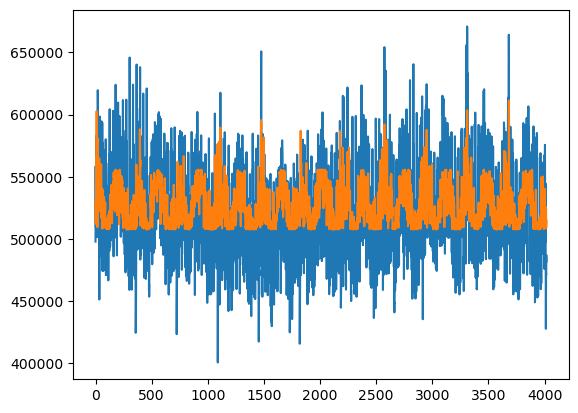

In [535]:
plt.plot(y)
plt.plot(pred)

In [536]:
from scipy.stats import pearsonr

In [537]:
pearsonr(y, pred)

(0.44265574845769745, 2.0686256884841898e-192)